In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np

In [2]:
# Make torch deterministic
_ = torch.manual_seed(0)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

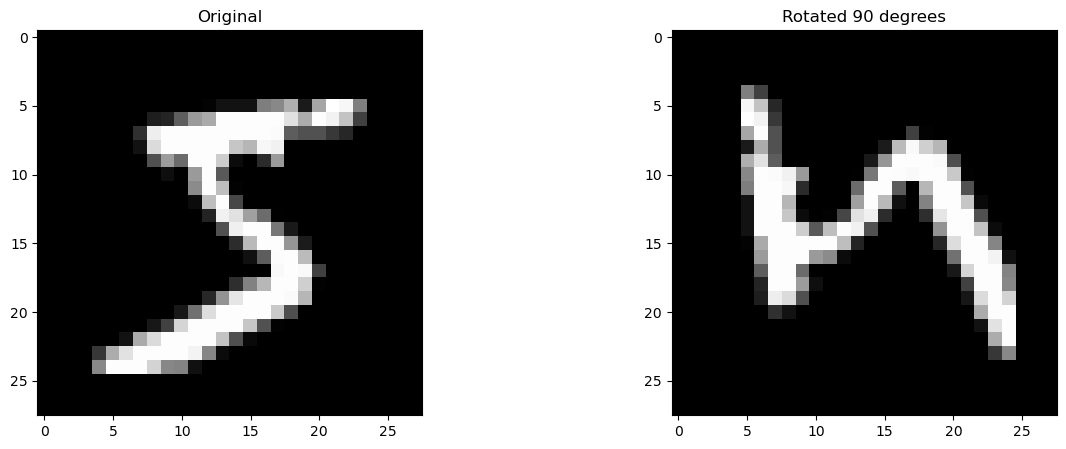

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

img_orig = torch.rot90(mnist_trainset[0][0], 0, [1, 2]).numpy()
img_rot_90 = torch.rot90(mnist_trainset[0][0], 1, [1, 2]).numpy()

axs[0].imshow(img_orig[0], cmap='gray')
axs[0].set_title('Original')

axs[1].imshow(img_rot_90[0], cmap='gray')
axs[1].set_title('Rotated 90 degrees')

plt.show()

In [5]:
class RotatedMNIST(Dataset):
    def __init__(self, mnist_dataset, id=None):
        self.mnist_dataset = mnist_dataset
        self.id = id

    def __len__(self):
        if self.id is not None:
            return len(self.mnist_dataset)
        
        return len(self.mnist_dataset) * 2

    def __getitem__(self, idx):
        if self.id is not None:
            img, label = self.mnist_dataset[idx]
            img = torch.rot90(img, self.id, [1, 2])
            mask = torch.zeros(2)
            mask[self.id] = 1
        else:    
            idx_orig = idx // 2
            img, label = self.mnist_dataset[idx_orig]
            img = torch.rot90(img, idx % 2, [1, 2])
            mask = torch.zeros(2)
            mask[idx % 2] = 1
            
        return img, mask, label

In [6]:
# Create a dataloader for the training
train_loader = torch.utils.data.DataLoader(RotatedMNIST(mnist_trainset), batch_size=10, shuffle=True)

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# Create an overly expensive neural network to classify MNIST digits
# Daddy got money, so I don't care about efficiency
class RichBoyNet(nn.Module):
    def __init__(self, hidden_size_1=1000, hidden_size_2=2000, r=8):
        super(RichBoyNet,self).__init__()
        self.linear1 = nn.Linear(28*28, hidden_size_1)
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.linear3 = nn.Linear(hidden_size_2, 10)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        
        # LoRA adapters (applied to second layer)
        self.adapters = nn.ModuleList([nn.Sequential(
            nn.Linear(hidden_size_1, r, bias=False),   # Low-rank projection
            nn.Linear(r, hidden_size_2, bias=False)    # Restore to original dimensions
        ) for _ in range(2)])

    def forward(self, img, mask):
        x = img.view(-1, 28*28)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        print(x.shape)
        
        adapter_output = sum([self.adapters[i](x) * mask[:, i].unsqueeze(1) for i in range(2)])
        
        x = self.linear2(x) + adapter_output
        x = self.relu(x)
        x = self.linear3(x)
        return x

net = RichBoyNet().to(device)

In [8]:
layer_2_weights = net.linear2.weight.detach().cpu().numpy()

In [9]:
def train(train_loader, net, epochs=5, total_iterations_limit=None):
    cross_el = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    total_iterations = 0

    for epoch in range(epochs):
        net.train()

        loss_sum = 0
        num_iterations = 0

        data_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}')
        if total_iterations_limit is not None:
            data_iterator.total = total_iterations_limit
        for data in data_iterator:
            num_iterations += 1
            total_iterations += 1
            x, mask, y = data
            x = x.to(device)
            mask = mask.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = net(x.view(-1, 28*28), mask)
            loss = cross_el(output, y)
            loss_sum += loss.item()
            avg_loss = loss_sum / num_iterations
            data_iterator.set_postfix(loss=avg_loss)
                       
            loss.backward()
            
            # Freezing the second layer
            net.linear2.weight.grad[:] = torch.zeros_like(net.linear2.weight.grad[:])
            net.linear2.bias.grad[:] = torch.zeros_like(net.linear2.bias.grad[:])
            
            optimizer.step()

            if total_iterations_limit is not None and total_iterations >= total_iterations_limit:
                return

train(train_loader, net, epochs=3)

Epoch 1:   0%|          | 0/12000 [00:00<?, ?it/s, loss=2.23]

torch.Size([10, 1000])


Epoch 1:   0%|          | 1/12000 [00:00<28:26,  7.03it/s, loss=2.23]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   0%|          | 25/12000 [00:00<01:38, 121.11it/s, loss=1.79]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   0%|          | 25/12000 [00:00<01:38, 121.11it/s, loss=1.58]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   0%|          | 47/12000 [00:00<01:15, 158.68it/s, loss=1.5] 

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   0%|          | 47/12000 [00:00<01:15, 158.68it/s, loss=1.42]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   1%|          | 69/12000 [00:00<01:05, 180.94it/s, loss=1.32]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   1%|          | 69/12000 [00:00<01:05, 180.94it/s, loss=1.29]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   1%|          | 89/12000 [00:00<01:04, 185.27it/s, loss=1.24]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   1%|          | 111/12000 [00:00<01:01, 194.64it/s, loss=1.21]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   1%|          | 111/12000 [00:00<01:01, 194.64it/s, loss=1.19]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   1%|          | 132/12000 [00:00<01:00, 197.57it/s, loss=1.13]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   1%|▏         | 153/12000 [00:00<00:59, 198.79it/s, loss=1.08]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   1%|▏         | 153/12000 [00:00<00:59, 198.79it/s, loss=1.06]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   1%|▏         | 174/12000 [00:00<00:59, 199.47it/s, loss=1.04]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   2%|▏         | 195/12000 [00:01<00:59, 199.56it/s, loss=1.03]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   2%|▏         | 195/12000 [00:01<00:59, 199.56it/s, loss=1.02]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   2%|▏         | 217/12000 [00:01<00:58, 202.09it/s, loss=1]   

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   2%|▏         | 217/12000 [00:01<00:58, 202.09it/s, loss=0.978]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   2%|▏         | 238/12000 [00:01<00:58, 201.91it/s, loss=0.969]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   2%|▏         | 238/12000 [00:01<00:58, 201.91it/s, loss=0.945]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   2%|▏         | 259/12000 [00:01<00:57, 204.20it/s, loss=0.918]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   2%|▏         | 259/12000 [00:01<00:57, 204.20it/s, loss=0.916]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   2%|▏         | 282/12000 [00:01<00:56, 208.73it/s, loss=0.902]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   3%|▎         | 303/12000 [00:01<00:56, 206.29it/s, loss=0.883]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   3%|▎         | 303/12000 [00:01<00:56, 206.29it/s, loss=0.877]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   3%|▎         | 326/12000 [00:01<00:55, 211.06it/s, loss=0.853]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   3%|▎         | 348/12000 [00:01<00:55, 210.25it/s, loss=0.834]

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


Epoch 1:   3%|▎         | 358/12000 [00:01<01:00, 193.05it/s, loss=0.826]


torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])



KeyboardInterrupt



In [10]:
layer_2_weights_after = net.linear2.weight.detach().cpu().numpy()

np.allclose(layer_2_weights, layer_2_weights_after)

True

In [11]:
# Load the MNIST test set
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader_orig = torch.utils.data.DataLoader(RotatedMNIST(mnist_testset, 0), batch_size=10, shuffle=True)
test_loader_rot = torch.utils.data.DataLoader(RotatedMNIST(mnist_testset, 1), batch_size=10, shuffle=True)

In [12]:
def test(test_loader, net):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            x, mask, y = data
            x = x.to(device)
            mask = mask.to(device)
            y = y.to(device)
            outputs = net(x.view(-1, 28*28), mask)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')
    
test(test_loader_orig, net)
test(test_loader_rot, net)

Accuracy of the network on the 10000 test images: 96.24%
Accuracy of the network on the 10000 test images: 96.8%


In [13]:
# Print some images and predictions
net.eval()

RichBoyNet(
  (linear1): Linear(in_features=784, out_features=1000, bias=True)
  (linear2): Linear(in_features=1000, out_features=2000, bias=True)
  (linear3): Linear(in_features=2000, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (adapters): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=1000, out_features=8, bias=False)
      (1): Linear(in_features=8, out_features=2000, bias=False)
    )
  )
)

Original images


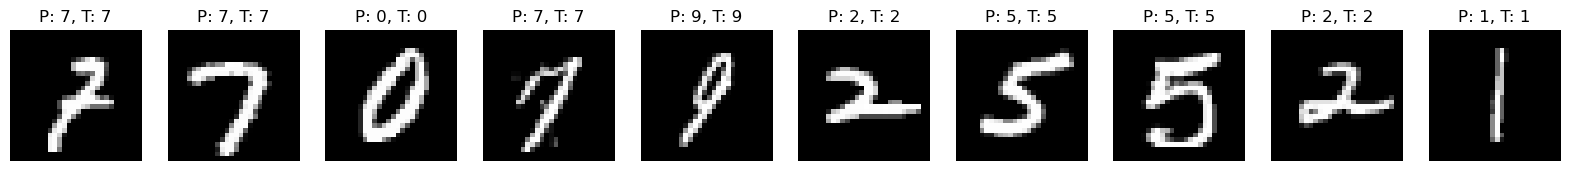

In [14]:
print('Original images')

dataiter = iter(test_loader_orig)
images, masks, labels = next(dataiter)

outputs = net(images.view(-1, 28*28).to(device), masks.to(device))
_, predicted = torch.max(outputs, 1)

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    img = images[i].numpy()[0]
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(f'P: {predicted[i]}, T: {labels[i]}')
    axs[i].axis('off')
    
plt.show()

Rotated images


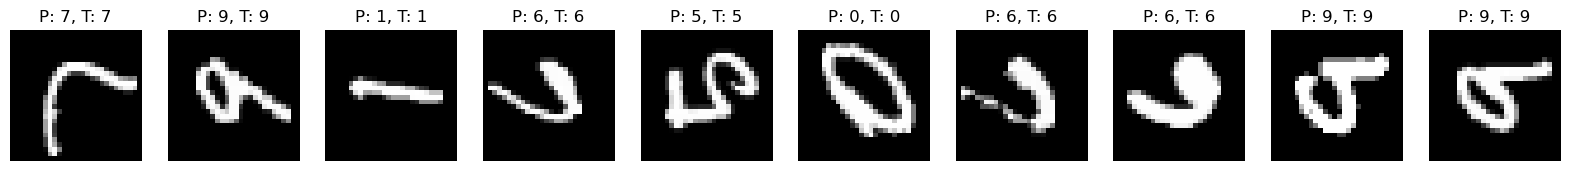

In [15]:
print('Rotated images')

dataiter = iter(test_loader_rot)
images, masks, labels = next(dataiter)

outputs = net(images.view(-1, 28*28).to(device), masks.to(device))
_, predicted = torch.max(outputs, 1)

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    img = images[i].numpy()[0]
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(f'P: {predicted[i]}, T: {labels[i]}')
    axs[i].axis('off')
    
plt.show()